In [153]:
from bs4 import BeautifulSoup
import requests
from functools import reduce
import re

In [2]:
import dart_fss as dart

api_key='84999fdf0b1ef796f290f1352b3cc91f43b5c2ea'
dart.set_api_key(api_key=api_key)

'84999fdf0b1ef796f290f1352b3cc91f43b5c2ea'

In [294]:
# DART 에 공시된 회사 리스트 불러오기
corp_list = dart.get_corp_list()

In [303]:
basic_info = corp_list.find_by_corp_code('00583424')

In [305]:
financial_reports = basic_info.extract_fs(bgn_de=20190101)

In [306]:
financial_reports.save()

'/Users/dooyeoung/Documents/study/fsdata/00583424_annual.xlsx'

In [10]:
cor_list = []
for cor in corp_list:
    cor_list.append( cor.info )


In [12]:
cdf = pd.DataFrame(cor_list)

In [15]:
cdf['stock_code'].value_counts()

002840    1
011500    1
348210    1
032390    1
051810    1
         ..
138490    1
111710    1
053060    1
054020    1
008020    1
Name: stock_code, Length: 3246, dtype: int64

In [19]:
cdf.to_csv('cor_list.csv', index=False)

In [2]:
import OpenDartReader
# Open DART API KEY 설정
api_key='84999fdf0b1ef796f290f1352b3cc91f43b5c2ea'

#dart.set_api_key(api_key=api_key)
dart = OpenDartReader(api_key) 

In [4]:
key_word_map = {
        '증자': 'irdsSttus',
        '배당': 'alotMatter',
        '자기주식': 'tesstkAcqsDspsSttus',
        '최대주주': 'hyslrSttus',
        '최대주주변동': 'hyslrChgSttus',
        '소액주주': 'mrhlSttus',
        '임원': 'exctvSttus',
        '직원': 'empSttus',
        '임원개인보수': 'hmvAuditIndvdlBySttus',
        '임원전체보수': 'hmvAuditAllSttus',
        '개인별보수': 'indvdlByPay',
        '타법인출자': 'otrCprInvstmntSttus',
    }

In [3]:
#dart.report('00583424', '임원', 2018) 

In [4]:
# 삼성전자 사업보고서 (2018.12) 원문 텍스트
xml_text = dart.document('20200429000691')

In [7]:
soup = BeautifulSoup(xml_text, 'lxml')

In [39]:
url = 'http://dart.fss.or.kr/dsab002/search.ax?textCrpNm=아모레퍼시픽&startDate=20200101&reportName=사업보고서'

In [ ]:
reportName	검색 보고서명
startDate	시작 기간
endDate	종료 기간
textCrpNm	회사명
maxResult	최대 검색 결과    

In [43]:
req = requests.get(url)
soup = BeautifulSoup(req.text, 'lxml')

In [61]:
for tr in soup.select('tbody tr'):
    #print(tr)
    link = tr.select_one('td:nth-of-type(3) a')
    link = link['href']

In [66]:
req = requests.get('http://dart.fss.or.kr' + link )
    

In [95]:
soup = BeautifulSoup(req.text, 'html.parser')

In [102]:
for script in soup.select('script'):
    if script.text:
        #print(script )
        break

In [241]:
lines = script.text.split('\n')
key_link = []
for idx in range(0, len(lines)):
    line = lines[idx].replace('\t', '') 
    if ' = new Tree.TreeNode({' in line:
         
        key = re.sub('\t| |"|,', '', lines[idx+1] ).split(':')[-1]
         
        while True:
            idx +=1
            line = lines[idx]
    
            if 'click: function() {viewDoc(' in line:
              
                viewdoc = re.sub('\t| |', '', line)
                
                value = re.sub('viewDoc\(|\)"|\'|click:function\(|\)|{|}|;', '', viewdoc).split(',')
                #print(value)
                key_link.append({'key': key, 'value':value})
                                         
                break

In [240]:
key_link

[{'key': '전체',
  'value': ['20200429000691', '7320835', '1', '855', '69740', 'dart3.xsd']},
 {'key': '정정신고(보고)',
  'value': ['20200429000691', '7320835', '1', '855', '69740', 'dart3.xsd']},
 {'key': '【대표이사등의확인】',
  'value': ['20200429000691', '7320835', '2', '70599', '436', 'dart3.xsd']},
 {'key': '사업보고서',
  'value': ['20200429000691', '7320835', '3', '71065', '4024', 'dart3.xsd']},
 {'key': '【대표이사등의확인】',
  'value': ['20200429000691', '7320835', '4', '75169', '456', 'dart3.xsd']},
 {'key': 'I.회사의개요',
  'value': ['20200429000691', '7320835', '5', '75629', '99177', 'dart3.xsd']},
 {'key': '1.회사의개요',
  'value': ['20200429000691', '7320835', '6', '75732', '34492', 'dart3.xsd']},
 {'key': '2.회사의연혁',
  'value': ['20200429000691', '7320835', '7', '110228', '11391', 'dart3.xsd']},
 {'key': '3.자본금변동사항',
  'value': ['20200429000691', '7320835', '8', '121623', '4828', 'dart3.xsd']},
 {'key': '4.주식의총수등',
  'value': ['20200429000691', '7320835', '9', '126455', '29455', 'dart3.xsd']},
 {'key': '5.의결

In [125]:
fdf_li = []
next_year = 2020
for year in range(2020, 2010, -1):
    
    if year > next_year:
        continue 
        
    doc  = dart.finstate('00583424', year)
    if doc is not None : 
       
        
        fdf = doc[ doc['account_nm'].isin(['매출액','당기순이익','법인세차감전 순이익', '영업이익'] ) ]
            
        df_li = []
        t1 = fdf[['fs_nm', 'account_nm', 'thstrm_dt','thstrm_nm','thstrm_amount']] 
        t1 = t1.rename(columns={'thstrm_dt':'date', 'thstrm_nm' : 'order', 'thstrm_amount':'amout'})
        df_li.append(t1)

        if 'frmtrm_amount' in fdf.columns:
            t2 = fdf[['fs_nm', 'account_nm', 'frmtrm_dt','frmtrm_nm','frmtrm_amount']] 
            t2 = t2.rename(columns={'frmtrm_dt':'date', 'frmtrm_nm' : 'order', 'frmtrm_amount':'amout'})
            df_li.append(t2)

        if 'bfefrmtrm_amount' in fdf.columns:
            t3 = fdf[['fs_nm', 'account_nm', 'bfefrmtrm_dt','bfefrmtrm_nm','bfefrmtrm_amount']]
            t3 = t3.rename(columns={'bfefrmtrm_dt':'date', 'bfefrmtrm_nm' : 'order', 'bfefrmtrm_amount':'amout'})
            df_li.append(t3)

        fdf = pd.concat(df_li)
        fdf['year'] = fdf['date'].map(lambda x: x.split('.')[0]).astype(int)
        next_year = fdf['year'].min() - 1
        
        fdf_li.append(fdf)
        
        print(year, next_year)
rdf = pd.concat(fdf_li).reset_index(drop=True)  

2019 2016
2016 2013


In [137]:
bdf = rdf[rdf['fs_nm']=='연결재무제표']
bdf = bdf[bdf['account_nm']=='법인세차감전 순이익']
bdf = bdf.sort_values('year', ascending=False)
bdf['amout'] = bdf['amout'].str.replace(',', '').astype(int)

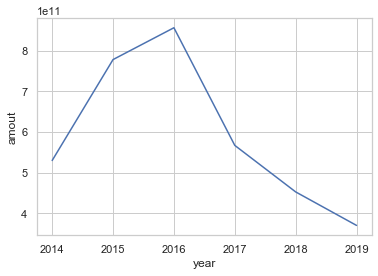

In [143]:
sns.lineplot(x='year', y='amout', data=bdf)

In [155]:
bdf

,fs_nm,account_nm,date,order,amout,year
2,연결재무제표,법인세차감전 순이익,2019.01.01 ~ 2019.12.31,제 14 기,370602220727,2019
10,연결재무제표,법인세차감전 순이익,2018.01.01 ~ 2018.12.31,제 13 기,452986706798,2018
18,연결재무제표,법인세차감전 순이익,2017.01.01 ~ 2017.12.31,제 12 기,567343864202,2017
26,연결재무제표,법인세차감전 순이익,2016.01.01 ~ 2016.12.31,제 11 기,856558217917,2016
34,연결재무제표,법인세차감전 순이익,2015.01.01 ~ 2015.12.31,제 10 기,778301120962,2015
42,연결재무제표,법인세차감전 순이익,2014.01.01 ~ 2014.12.31,제 9 기,530225625614,2014


In [156]:
bdf.iloc[1:]

,fs_nm,account_nm,date,order,amout,year
10,연결재무제표,법인세차감전 순이익,2018.01.01 ~ 2018.12.31,제 13 기,452986706798,2018
18,연결재무제표,법인세차감전 순이익,2017.01.01 ~ 2017.12.31,제 12 기,567343864202,2017
26,연결재무제표,법인세차감전 순이익,2016.01.01 ~ 2016.12.31,제 11 기,856558217917,2016
34,연결재무제표,법인세차감전 순이익,2015.01.01 ~ 2015.12.31,제 10 기,778301120962,2015
42,연결재무제표,법인세차감전 순이익,2014.01.01 ~ 2014.12.31,제 9 기,530225625614,2014


In [249]:
dart.attach_docs('20200429000691')

[('감   사   보   고   서',
  'http://dart.fss.or.kr/report/viewer.do?rcpNo=20200330003631&dcmNo=7201026&eleId=1&offset=1718&length=1886&dtd=dart3.xsd'),
 ('독립된 감사인의 감사보고서',
  'http://dart.fss.or.kr/report/viewer.do?rcpNo=20200330003631&dcmNo=7201026&eleId=2&offset=7744&length=7481&dtd=dart3.xsd'),
 ('(첨부)재 무 제 표',
  'http://dart.fss.or.kr/report/viewer.do?rcpNo=20200330003631&dcmNo=7201026&eleId=3&offset=15255&length=457349&dtd=dart3.xsd'),
 ('주석',
  'http://dart.fss.or.kr/report/viewer.do?rcpNo=20200330003631&dcmNo=7201026&eleId=4&offset=81518&length=391072&dtd=dart3.xsd'),
 ('내부회계관리제도 감사 또는 검토의견',
  'http://dart.fss.or.kr/report/viewer.do?rcpNo=20200330003631&dcmNo=7201026&eleId=5&offset=473020&length=4998&dtd=dart3.xsd'),
 ('외부감사 실시내용',
  'http://dart.fss.or.kr/report/viewer.do?rcpNo=20200330003631&dcmNo=7201026&eleId=6&offset=478048&length=22585&dtd=dart3.xsd'),
 ('감사의 감사보고서',
  'http://dart.fss.or.kr/report/viewer.do?rcpNo=20200330003631&dcmNo=7201031&eleId=1&offset=595&length=274&dtd

In [280]:
xsdurl = 'http://dart.fss.or.kr/report/viewer.do?rcpNo=20200330003631&dcmNo=7201027&eleId=3&offset=14015&length=493292&dtd=dart3.xsd'


In [307]:
#STEP 4
from urllib.request import urlopen
resultXML=requests.get(xsdurl)  #this is for response of XML
#STEP 5
xmlsoup=BeautifulSoup(resultXML.text,'html.parser')
tables=xmlsoup.findAll("table")


In [317]:
tables

[<table class="nb" width="600">
 <colgroup>
 <col width="600"/>
 </colgroup>
 <tbody>
 <tr>
 <td align="CENTER" height="29" style="font-size:14pt;font-weight:bold;" width="600">주식회사 아모레퍼시픽 및 그 종속기업</td>
 </tr>
 </tbody>
 </table>, <table class="nb" width="600">
 <colgroup>
 <col width="342"/>
 <col width="258"/>
 </colgroup>
 <tbody>
 <tr>
 <td align="CENTER" colspan="2" height="24" style='font-family:"바탕", Batang;font-size:14pt;' width="600">제 14 기</td>
 </tr>
 <tr>
 <td align="RIGHT" height="20" width="342">2019년 01월 01일</td>
 <td height="20" width="258">부터</td>
 </tr>
 <tr>
 <td align="RIGHT" height="20" valign="TOP" width="342">2019년 12월 31일</td>
 <td height="20" valign="TOP" width="258">까지</td>
 </tr>
 </tbody>
 </table>, <table class="nb" width="600">
 <colgroup>
 <col width="342"/>
 <col width="258"/>
 </colgroup>
 <tbody>
 <tr>
 <td align="CENTER" colspan="2" height="24" style='font-family:"바탕", Batang;font-size:14pt;' width="600">제 13 기</td>
 </tr>
 <tr>
 <td align="RIGHT" hei

In [320]:
url = 'https://opendart.fss.or.kr/api/fnlttSinglAcnt.json'

In [318]:
PARAMS = {
  'crtfc_key': api_key, # API 인증키
  'corp_code': '00583424', # 삼성전자 고유번호
  'bsns_year': '2019', # 사업연도(4자리)
  'reprt_code': '11011', # 사업보고서
}

In [321]:
resp = requests.get(url = url, params = PARAMS)


In [325]:
data_json = resp.json()

In [331]:
if data_json['status'] == "000":
    detail = data_json['list']
    df = pd.DataFrame(detail)

In [ ]:
'법인세차감전 순이익', '매출액','영업이익',''''

In [335]:
df

,rcept_no,reprt_code,bsns_year,corp_code,stock_code,fs_div,fs_nm,sj_div,sj_nm,account_nm,thstrm_nm,thstrm_dt,thstrm_amount,frmtrm_nm,frmtrm_dt,frmtrm_amount,bfefrmtrm_nm,bfefrmtrm_dt,bfefrmtrm_amount,ord
0,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,BS,재무상태표,유동자산,제 14 기,2019.12.31 현재,"1,803,063,670,498",제 13 기,2018.12.31 현재,"1,567,235,920,188",제 12 기,2017.12.31 현재,"1,677,479,147,969",1
1,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,BS,재무상태표,비유동자산,제 14 기,2019.12.31 현재,"4,185,944,120,149",제 13 기,2018.12.31 현재,"3,803,901,297,634",제 12 기,2017.12.31 현재,"3,698,205,090,627",3
2,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,BS,재무상태표,자산총계,제 14 기,2019.12.31 현재,"5,989,007,790,647",제 13 기,2018.12.31 현재,"5,371,137,217,822",제 12 기,2017.12.31 현재,"5,375,684,238,596",5
3,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,BS,재무상태표,유동부채,제 14 기,2019.12.31 현재,"1,066,567,435,582",제 13 기,2018.12.31 현재,"763,211,930,043",제 12 기,2017.12.31 현재,"1,046,448,068,104",7
4,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,BS,재무상태표,비유동부채,제 14 기,2019.12.31 현재,"423,599,551,940",제 13 기,2018.12.31 현재,"161,508,205,332",제 12 기,2017.12.31 현재,"153,862,015,709",9
5,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,BS,재무상태표,부채총계,제 14 기,2019.12.31 현재,"1,490,166,987,522",제 13 기,2018.12.31 현재,"924,720,135,375",제 12 기,2017.12.31 현재,"1,200,310,083,813",11
6,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,BS,재무상태표,자본금,제 14 기,2019.12.31 현재,"34,508,160,000",제 13 기,2018.12.31 현재,"34,508,160,000",제 12 기,2017.12.31 현재,"34,508,160,000",13
7,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,BS,재무상태표,이익잉여금,제 14 기,2019.12.31 현재,"3,873,789,578,852",제 13 기,2018.12.31 현재,"3,726,002,772,481",제 12 기,2017.12.31 현재,"3,456,502,861,670",17
8,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,BS,재무상태표,자본총계,제 14 기,2019.12.31 현재,"4,498,840,803,125",제 13 기,2018.12.31 현재,"4,446,417,082,447",제 12 기,2017.12.31 현재,"4,175,374,154,783",21
9,20200429000691,11011,2019,00583424,090430,CFS,연결재무제표,IS,손익계산서,매출액,제 14 기,2019.01.01 ~ 2019.12.31,"5,580,142,192,519",제 13 기,2018.01.01 ~ 2018.12.31,"5,277,844,561,808",제 12 기,2017.01.01 ~ 2017.12.31,"5,123,825,882,104",23
